# Benchmarking Foundation Models Notebook 

Authors:
- Helio Halperin (heliohalperin@gmail.com)
- Simon Lee (simonlee711@g.ucla.edu)

2024

In [3]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.21.0
# !pip install fastprogress
# !pip install lightgbm

In [3]:
!pwd

/root/antibiotics-fm-benchmark


In [33]:
# Basic imports
import numpy as np
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn

# AWS imports
# import boto3
# from sagemaker import get_execution_role

# I/O imports
from io import StringIO

# Progress and visualization imports
from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Sklearn metrics imports
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Transformers imports
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, 
    DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, 
    AdamW, get_scheduler
)
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_metric

# PyTorch data handling
from torch.utils.data import DataLoader

from scripts.train_test_split import custom_train_test_split
#from scripts.encoder import encode_texts, encode_texts_biolm
#from scripts.train_test import evaluate_antibiotics_with_confidence_intervals, print_results
#from scripts.plot import plot_roc_curves, plot_auprc_curves, calculate_confidence_interval_curves

# read in data

In [34]:
data = pd.read_csv("./data/antibiotics_labels.csv")
display(data)

,subject_id,stay_id,hadm_id,arrival,triage,medrecon,vitals,codes,pyxis,patient_paragraph,...,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,LEVOFLOXACIN,NITROFURANTOIN,OXACILLIN,RIFAMPIN,TETRACYCLINE,TRIMETHOPRIM/SULFA,VANCOMYCIN
0,10002443,33425241,21329021,"Patient 10002443, a 53 year old white male, ar...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2183-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10002443, a 53 year old white male, ar...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,10005858,39055405,29352282,"Patient 10005858, a 62 year old white female, ...","At triage: temperature was 102.7, pulse was 93...",The patient was previously taking the followin...,The patient had the following vitals: At 2172-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10005858, a 62 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,10014078,38676365,25809882,"Patient 10014078, a 60 year old unable to obta...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014078, a 60 year old unable to obta...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,19989126,35420737,22853928,"Patient 19989126, a 45 year old asian female, ...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19989126, a 45 year old asian female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5978,19990821,35896332,27777812,"Patient 19990821, a 70 year old unknown male, ...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient has no diagnostic codes recorded.,The patient received the following medications...,"Patient 19990821, a 70 year old unknown male, ...",...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5979,19991805,34001852,23646288,"Patient 19991805, a 80 year old white female, ...","At triage: temperature was 97.9, pulse was 67....",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19991805, a 80 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5980,19994772,37554330,29199248,"Patient 19994772, a 54 year old white female, ...","At triage: temperature was 96.7, pulse was 79....",The patient was previously taking the followin...,The patient had the following vitals: At 2181-...,The patient received the following diagnostic ...

In [35]:
# List of antibiotics we are interested in
############################################
## We may or may not study NITROFURANTOIN ## 
## Because only 6% of patients were       ##
## prescribed it                          ##
############################################

antibiotics = ['CLINDAMYCIN', 'ERYTHROMYCIN', 'GENTAMICIN', 'LEVOFLOXACIN', 
               'OXACILLIN', 'TETRACYCLINE', 'TRIMETHOPRIM/SULFA', 
               'VANCOMYCIN']

In [36]:
# # Split data into 80% and 20$ cuts
train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print('TRAIN:', len(train), 'TEST:', len(test))

TRAIN: 4844 TEST: 599


# DistilBERT (baseline)

In [17]:
# Generate Embeddings for each set of data
## We can plug in any models found on the huggingface platform
##
X_train = encode_texts('distilbert-base-uncased', train['patient_paragraph'].tolist())
X_test = encode_texts('distilbert-base-uncased', test['patient_paragraph'].tolist())

In [ ]:

## Evaluate 
distilbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)



# pickle files. Saving variables into pickle files. Save all your results in these special files. 

In [37]:
import pickle
def save_pickle(results, filename):
    """
    Creates a new pickle file

    results: the name of the variable
    filename: the name of the file
    """
    filename = f"{filename}.pickle"

    file_path=f'./results/{filename}'
    with open(file_path, 'wb') as file:
        pickle.dump(results, file)

    print(f"The variable {filename} has been saved successfully.")

def load_pickle(filename):
    """
    Loads in the pickle file

    filename: the name of the file
    """
    file_path=f'./results/{filename}.pickle'
    loaded_data = None
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)

    print(f"The variable {filename} has been loaded successfully.")

    return loaded_data


In [ ]:
distilbert_results = load_pickle('DistilBERT')

# Biomegatron

In [ ]:
X_train = encode_texts('EMBO/BioMegatron345mUncased', train['patient_paragraph'].tolist())
X_test = encode_texts('EMBO/BioMegatron345mUncased', test['patient_paragraph'].tolist())
## Make sure to rename
biomegatron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biomegatron_results)

save_pickle(biomegatron_results, "biomegatron")
biomegatron_results = load_pickle('biomegatron')

# Took too long, should use AWS

# Medbert

In [ ]:
X_train = encode_texts("Charangan/MedBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("Charangan/MedBERT", test['patient_paragraph'].tolist())
## Make sure to rename
medbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(medbert_results)

save_pickle(medbert_results, "medBERT")
medbert_results = load_pickle('medBERT')

Bluebert

In [ ]:
X_train = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", train['patient_paragraph'].tolist())
X_test = encode_texts("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12", test['patient_paragraph'].tolist())
## Make sure to rename
bluebert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(bluebert_results)

save_pickle(bluebert_results, "BlueBERT")
bluebert_results = load_pickle('BlueBERT')

Biobert

In [ ]:
X_train = encode_texts("pritamdeka/BioBert-PubMed200kRCT", train['patient_paragraph'].tolist())
X_test = encode_texts("pritamdeka/BioBert-PubMed200kRCT", test['patient_paragraph'].tolist())
## Make sure to rename
biobert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biobert_results)

save_pickle(biobert_results, "BioBERT")
biobert_results = load_pickle('BioBERT')

In [ ]:
PubMedBERT

In [ ]:
X_train = encode_texts("NeuML/pubmedbert-base-embeddings", train['patient_paragraph'].tolist())
X_test = encode_texts("NeuML/pubmedbert-base-embeddings", test['patient_paragraph'].tolist())
## Make sure to rename
pubmedbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(pubmedbert_results)

save_pickle(pubmedbert_results, "PubMedBERT")
pubmedbert_results = load_pickle('PubMedBERT')

In [ ]:
Gatotron - Large model

In [32]:
X_train = encode_texts("UFNLP/gatortronS", train['patient_paragraph'].tolist())
X_test = encode_texts("UFNLP/gatortronS", test['patient_paragraph'].tolist())
## Make sure to rename
gatotron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(gatotron_results)

save_pickle(gatotron_results, "Gatotron")
gatotron_results = load_pickle('Gatotron')

embeddings are generated
embeddings are generated


Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:17<02:00, 17.25s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [00:34<01:43, 17.33s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [00:53<01:31, 18.23s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [01:11<01:11, 17.92s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [01:28<00:52, 17.64s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


/root/simonlee/src/antibiotics-fm-benchmark/scripts/train_test.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [01:46<00:35, 17.69s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [02:03<00:17, 17.68s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [02:20<00:00, 17.62s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7758 +/- 0.0306, MCC: 0.3637, ROC-AUC: 0.7108 +/- 0.0418, PRC-AUC: 0.7526 +/- 0.0485
Results for ERYTHROMYCIN:
  Test - F1: 0.6563 +/- 0.0416, MCC: 0.3569, ROC-AUC: 0.7473 +/- 0.0382, PRC-AUC: 0.6753 +/- 0.0605
Results for GENTAMICIN:
  Test - F1: 0.9773 +/- 0.0088, MCC: 0.3969, ROC-AUC: 0.6840 +/- 0.0999, PRC-AUC: 0.9703 +/- 0.0176
Results for LEVOFLOXACIN:
  Test - F1: 0.8185 +/- 0.0270, MCC: 0.4571, ROC-AUC: 0.8032 +/- 0.0327, PRC-AUC: 0.8546 +/- 0.0347
Results for OXACILLIN:
  Test - F1: 0.7877 +/- 0.0300, MCC: 0.4237, ROC-AUC: 0.7695 +/- 0.0380, PRC-AUC: 0.7976 +/- 0.0475
Results for TETRACYCLINE:
  Test - F1: 0.9045 +/- 0.0184, MCC: 0.3779, ROC-AUC: 0.6344 +/- 0.0582, PRC-AUC: 0.8435 +/- 0.0431
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9107 +/- 0.0173, MCC: 0.4356, ROC-AUC: 0.7103 +/- 0.0551, PRC-AUC: 0.8767 +/- 0.0376
Results for VANCOMYCIN:
  Test - F1: 0.7312 +/- 0.0355, MCC: 0.3562, ROC-AUC: 0.7558 +/- 0.0371, PRC-AUC: 0.7851 +/- 0

In [ ]:
BiomedRoBERTa

In [ ]:
X_train = encode_texts("allenai/biomed_roberta_base", train['patient_paragraph'].tolist())
X_test = encode_texts("allenai/biomed_roberta_base", test['patient_paragraph'].tolist())
## Make sure to rename
biomedroberta_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biomedroberta_results)

save_pickle(biomedroberta_results, "BiomedRoBERTa")
biomedroberta_results = load_pickle('BiomedRoBERTa')

In [ ]:
ClinicalBERT

In [ ]:
X_train = encode_texts("medicalai/ClinicalBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("medicalai/ClinicalBERT", test['patient_paragraph'].tolist())
## Make sure to rename
clinicalbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(clinicalbert_results)

save_pickle(clinicalbert_results, "ClinicalBERT")
clinicalbert_results = load_pickle('ClinicalBERT')

In [ ]:
Bio+ClinicalBERT

In [ ]:
X_train = encode_texts("emilyalsentzer/Bio_ClinicalBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("emilyalsentzer/Bio_ClinicalBERT", test['patient_paragraph'].tolist())
## Make sure to rename
bio_clinicalbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(bio_clinicalbert_results)

save_pickle(clinicalbert_results, "Bio+ClinicalBERT")
bio_clinicalbert_results = load_pickle('Bio+ClinicalBERT')

In [ ]:
SciBERT

In [ ]:
X_train = encode_texts("allenai/scibert_scivocab_uncased", train['patient_paragraph'].tolist())
X_test = encode_texts("allenai/scibert_scivocab_uncased", test['patient_paragraph'].tolist())
## Make sure to rename
scibert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(scibert_results)

save_pickle(scibert_results, "sciBERT")
scibert_results = load_pickle('sciBERT')

In [ ]:
BioLM - Needs to be revisited

In [10]:
X_train = encode_texts_biolm("EMBO/bio-lm", train['patient_paragraph'].tolist())
X_test = encode_texts_biolm("EMBO/bio-lm", test['patient_paragraph'].tolist())
## Make sure to rename
biolm_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biolm_results)

save_pickle(biolm_results, "bioLM")
biolm_results = load_pickle('bioLM')

Some weights of RobertaModel were not initialized from the model checkpoint at EMBO/bio-lm and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings are generated


Some weights of RobertaModel were not initialized from the model checkpoint at EMBO/bio-lm and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings are generated


Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


/root/simonlee/src/antibiotics-fm-benchmark/scripts/train_test.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:13<01:32, 13.21s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [00:26<01:18, 13.17s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [00:41<01:09, 13.92s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [00:54<00:54, 13.65s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [01:07<00:40, 13.50s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [01:21<00:26, 13.49s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [01:34<00:13, 13.52s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [01:48<00:00, 13.50s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7816 +/- 0.0297, MCC: 0.3693, ROC-AUC: 0.7289 +/- 0.0402, PRC-AUC: 0.7641 +/- 0.0494
Results for ERYTHROMYCIN:
  Test - F1: 0.6598 +/- 0.0408, MCC: 0.3636, ROC-AUC: 0.7517 +/- 0.0385, PRC-AUC: 0.6821 +/- 0.0618
Results for GENTAMICIN:
  Test - F1: 0.9778 +/- 0.0081, MCC: 0.3667, ROC-AUC: 0.6685 +/- 0.1171, PRC-AUC: 0.9660 +/- 0.0199
Results for LEVOFLOXACIN:
  Test - F1: 0.8215 +/- 0.0276, MCC: 0.4675, ROC-AUC: 0.7987 +/- 0.0393, PRC-AUC: 0.8276 +/- 0.0465
Results for OXACILLIN:
  Test - F1: 0.7968 +/- 0.0303, MCC: 0.4489, ROC-AUC: 0.7852 +/- 0.0352, PRC-AUC: 0.8022 +/- 0.0472
Results for TETRACYCLINE:
  Test - F1: 0.9040 +/- 0.0185, MCC: 0.3718, ROC-AUC: 0.6662 +/- 0.0601, PRC-AUC: 0.8593 +/- 0.0401
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9097 +/- 0.0179, MCC: 0.4239, ROC-AUC: 0.7172 +/- 0.0547, PRC-AUC: 0.8871 +/- 0.0350
Results for VANCOMYCIN:
  Test - F1: 0.7306 +/- 0.0325, MCC: 0.3430, ROC-AUC: 0.7758 +/- 0.0367, PRC-AUC: 0.7967 +/- 0

In [ ]:
RadBERT

In [11]:
X_train = encode_texts("StanfordAIMI/RadBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("StanfordAIMI/RadBERT", test['patient_paragraph'].tolist())
## Make sure to rename
radbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(radbert_results)

save_pickle(radbert_results, "RadBERT")
radbert_results = load_pickle('RadBERT')

embeddings are generated
embeddings are generated


Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:43<05:05, 43.65s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [01:28<04:27, 44.53s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [02:20<03:58, 47.75s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


/root/antibiotics-fm-benchmark/scripts/train_test.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  50%|█████     | 4/8 [03:07<03:09, 47.34s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [03:51<02:19, 46.34s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [04:39<01:33, 46.72s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [05:23<00:45, 45.99s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [06:07<00:00, 45.94s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7777 +/- 0.0303, MCC: 0.3639, ROC-AUC: 0.7307 +/- 0.0406, PRC-AUC: 0.7722 +/- 0.0482
Results for ERYTHROMYCIN:
  Test - F1: 0.6704 +/- 0.0429, MCC: 0.4075, ROC-AUC: 0.7683 +/- 0.0405, PRC-AUC: 0.7084 +/- 0.0576
Results for GENTAMICIN:
  Test - F1: 0.9772 +/- 0.0082, MCC: 0.3969, ROC-AUC: 0.6876 +/- 0.1111, PRC-AUC: 0.9687 +/- 0.0186
Results for LEVOFLOXACIN:
  Test - F1: 0.8121 +/- 0.0281, MCC: 0.4370, ROC-AUC: 0.7985 +/- 0.0348, PRC-AUC: 0.8424 +/- 0.0428
Results for OXACILLIN:
  Test - F1: 0.7899 +/- 0.0292, MCC: 0.4285, ROC-AUC: 0.7778 +/- 0.0373, PRC-AUC: 0.8054 +/- 0.0453
Results for TETRACYCLINE:
  Test - F1: 0.9042 +/- 0.0179, MCC: 0.3706, ROC-AUC: 0.6627 +/- 0.0542, PRC-AUC: 0.8727 +/- 0.0357
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9075 +/- 0.0180, MCC: 0.4099, ROC-AUC: 0.6999 +/- 0.0587, PRC-AUC: 0.8835 +/- 0.0353
Results for VANCOMYCIN:
  Test - F1: 0.7253 +/- 0.0332, MCC: 0.3339, ROC-AUC: 0.7492 +/- 0.0369, PRC-AUC: 0.7755 +/- 0

In [ ]:
LinkBERT

In [12]:
X_train = encode_texts("michiyasunaga/LinkBERT-large", train['patient_paragraph'].tolist())
X_test = encode_texts("michiyasunaga/LinkBERT-large", test['patient_paragraph'].tolist())
## Make sure to rename
linkbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(linkbert_results)

save_pickle(linkbert_results, "LinkBERT")
linkbert_results = load_pickle('LinkBERT')

embeddings are generated
embeddings are generated


Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [01:00<07:00, 60.14s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [02:02<06:08, 61.36s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [03:09<05:18, 63.79s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [04:10<04:10, 62.70s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


/root/antibiotics-fm-benchmark/scripts/train_test.py:101: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [05:10<03:05, 61.87s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [06:13<02:04, 62.20s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [07:14<01:01, 61.97s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [08:14<00:00, 61.78s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7827 +/- 0.0302, MCC: 0.3841, ROC-AUC: 0.7390 +/- 0.0378, PRC-AUC: 0.7788 +/- 0.0486
Results for ERYTHROMYCIN:
  Test - F1: 0.6453 +/- 0.0406, MCC: 0.3301, ROC-AUC: 0.7309 +/- 0.0402, PRC-AUC: 0.6687 +/- 0.0598
Results for GENTAMICIN:
  Test - F1: 0.9782 +/- 0.0081, MCC: 0.3953, ROC-AUC: 0.6991 +/- 0.1193, PRC-AUC: 0.9681 +/- 0.0195
Results for LEVOFLOXACIN:
  Test - F1: 0.8275 +/- 0.0270, MCC: 0.5104, ROC-AUC: 0.8001 +/- 0.0382, PRC-AUC: 0.8440 +/- 0.0372
Results for OXACILLIN:
  Test - F1: 0.7922 +/- 0.0314, MCC: 0.4477, ROC-AUC: 0.7725 +/- 0.0387, PRC-AUC: 0.7846 +/- 0.0519
Results for TETRACYCLINE:
  Test - F1: 0.9039 +/- 0.0183, MCC: 0.3718, ROC-AUC: 0.6697 +/- 0.0605, PRC-AUC: 0.8626 +/- 0.0401
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9105 +/- 0.0178, MCC: 0.4239, ROC-AUC: 0.7187 +/- 0.0557, PRC-AUC: 0.8916 +/- 0.0318
Results for VANCOMYCIN:
  Test - F1: 0.7348 +/- 0.0353, MCC: 0.3820, ROC-AUC: 0.7771 +/- 0.0364, PRC-AUC: 0.8029 +/- 0

In [38]:
biobert_results = load_pickle('BioBERT')
medbert_results = load_pickle('medBERT')
distilbert_results = load_pickle('DistilBERT')
biomegatron_results = load_pickle('biomegatron')
bluebert_results = load_pickle('BlueBERT')
pubmedbert_results = load_pickle('PubMedBERT')
gatotron_results = load_pickle('Gatotron')
biomedroberta_results = load_pickle('BiomedRoBERTa')
clinicalbert_results = load_pickle('ClinicalBERT')
bio_clinicalbert_results = load_pickle('Bio+ClinicalBERT')
scibert_results = load_pickle('sciBERT')
biolm_results = load_pickle('bioLM')
radbert_results = load_pickle('RadBERT')
linkbert_results = load_pickle('LinkBERT')

The variable BioBERT has been loaded successfully.
The variable medBERT has been loaded successfully.
The variable DistilBERT has been loaded successfully.
The variable biomegatron has been loaded successfully.
The variable BlueBERT has been loaded successfully.
The variable PubMedBERT has been loaded successfully.
The variable Gatotron has been loaded successfully.
The variable BiomedRoBERTa has been loaded successfully.
The variable ClinicalBERT has been loaded successfully.
The variable Bio+ClinicalBERT has been loaded successfully.
The variable sciBERT has been loaded successfully.
The variable bioLM has been loaded successfully.
The variable RadBERT has been loaded successfully.
The variable LinkBERT has been loaded successfully.


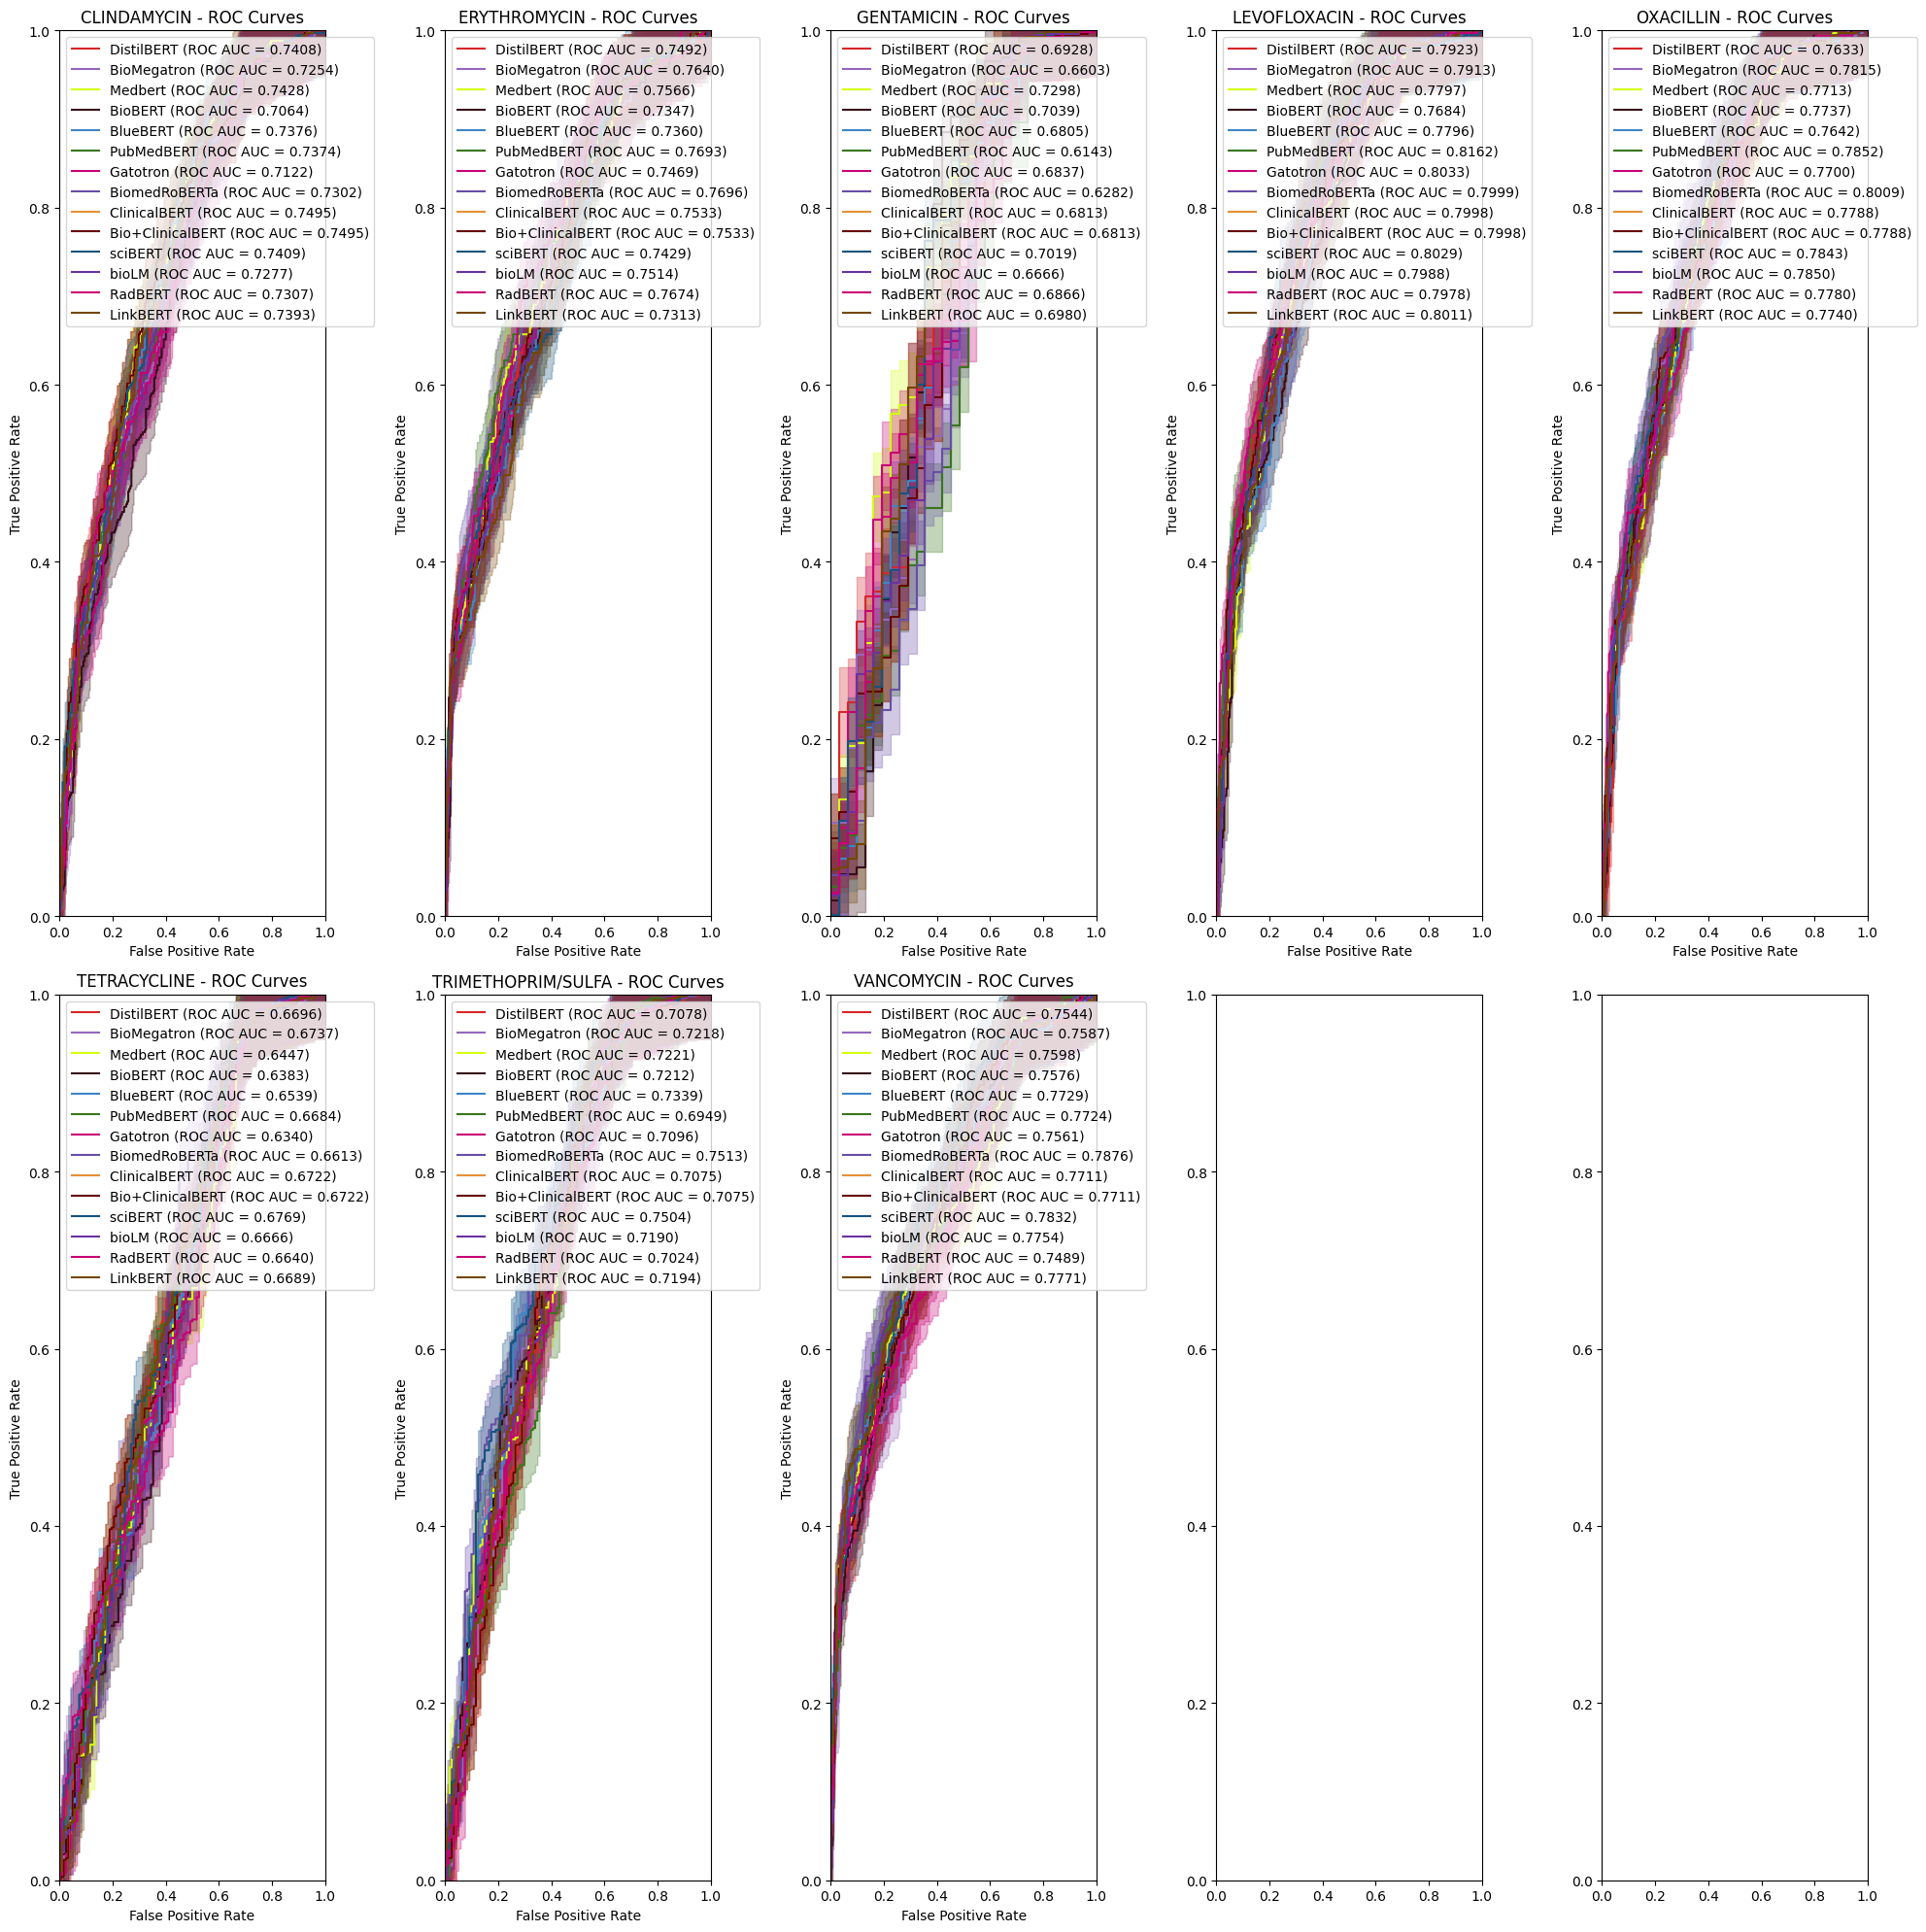

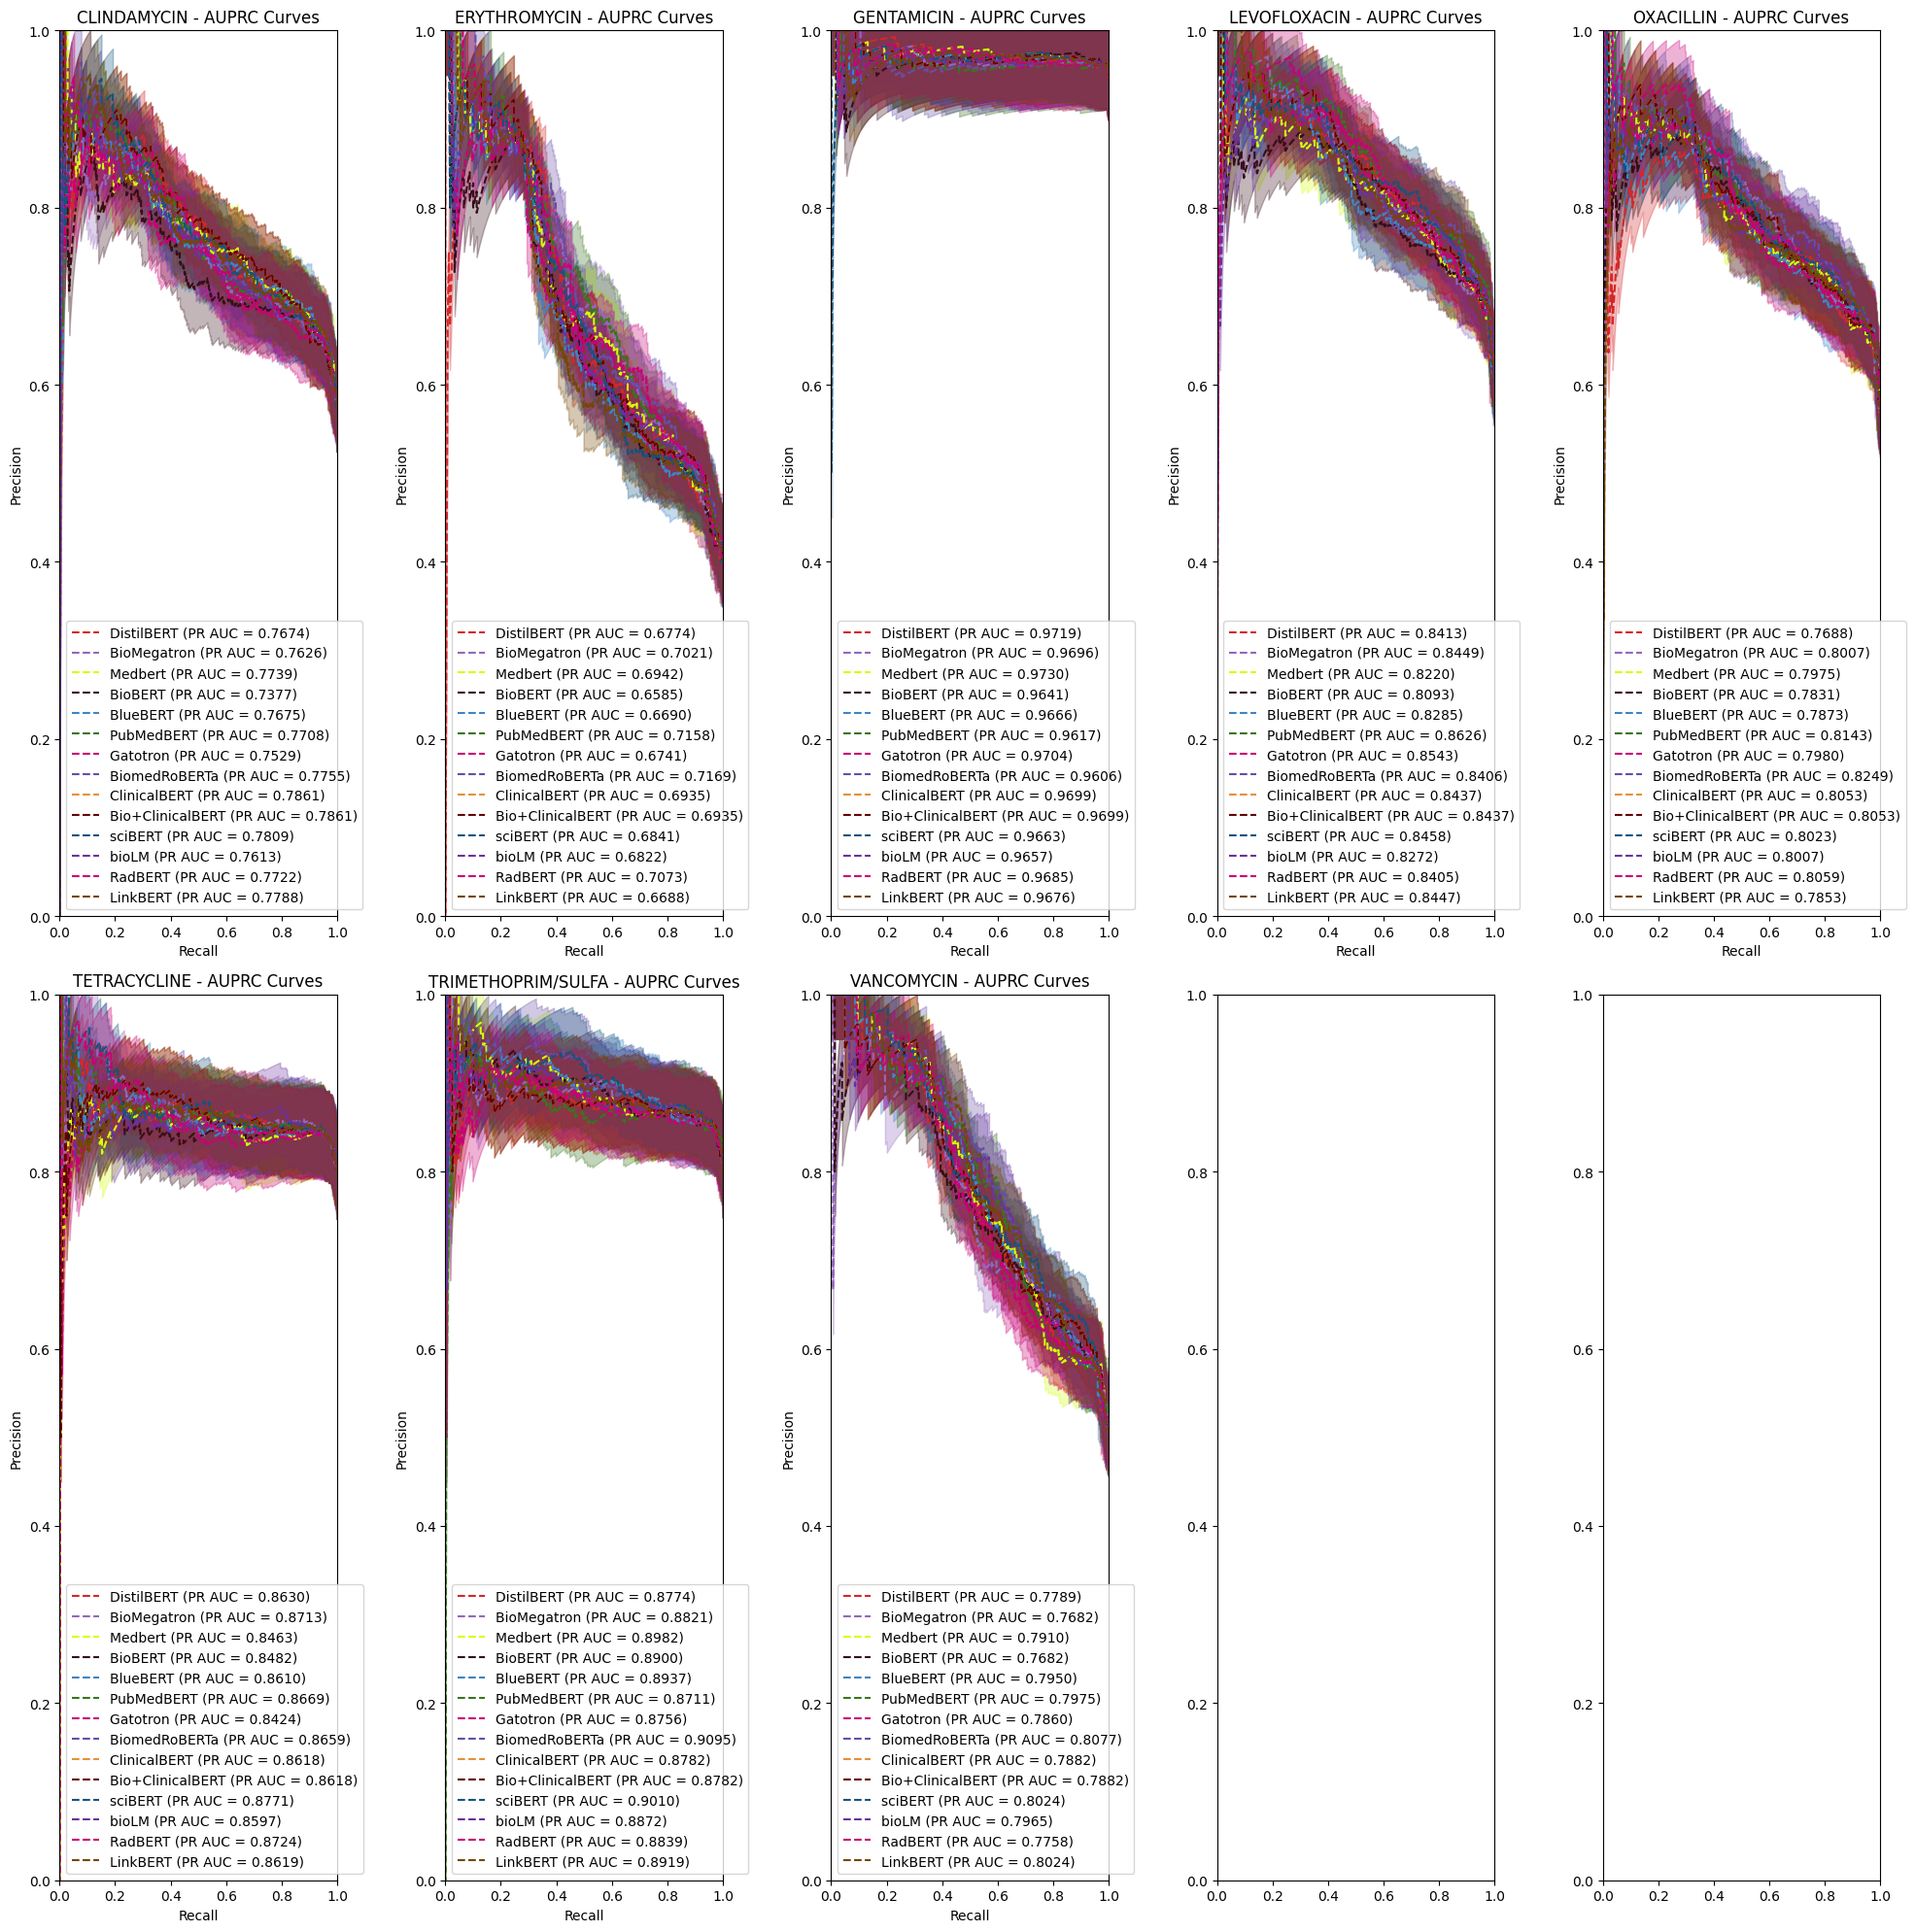

In [39]:
model_colors = {
    "DistilBERT": '#d62728',
    "BioMegatron": '#9467bd',
    "Medbert": "#d3ff0d",
    "BioBERT": "#370e19",
    "BlueBERT": "#3d85c6",
    "PubMedBERT": "#38761d",
    "Gatotron": "#c90076",
    "BiomedRoBERTa": "#674ea7",
    "ClinicalBERT": "#e69138",
    "Bio+ClinicalBERT": "#660000",
    "sciBERT": "#16537e",
    "bioLM": "#6a329f",
    "RadBERT": "#c90076",
    "LinkBERT": "#744700"
}

# Dictionaries with their corresponding model names
dictionaries = [
    (distilbert_results, "DistilBERT"),
    (biomegatron_results, "BioMegatron"),
    (medbert_results, "Medbert"),
    (biobert_results, "BioBERT"),
    (bluebert_results, "BlueBERT"),
    (pubmedbert_results, "PubMedBERT"),
    (gatotron_results, "Gatotron"),
    (biomedroberta_results, "BiomedRoBERTa"),
    (clinicalbert_results, "ClinicalBERT"),
    (bio_clinicalbert_results, "Bio+ClinicalBERT"),
    (scibert_results, "sciBERT"),
    (biolm_results, "bioLM"),
    (radbert_results, "RadBERT"),
    (linkbert_results, "LinkBERT")
]
plot_roc_curves(antibiotics, dictionaries, model_colors)
plot_auprc_curves(antibiotics, dictionaries, model_colors)

In [40]:
def plot_bar_auprc(antibiotics, dictionaries, model_colors, figsize=(20, 20)):
    """
    Plots bar charts for AUPRC values for multiple models and antibiotics, including error bars for confidence intervals,
    sorted from best to worst.

    Parameters:
    - antibiotics: List of antibiotics
    - dictionaries: List of tuples containing (dictionary, model_name)
    - model_colors: Dictionary of colors keyed by model_name
    - figsize: Tuple for figure size

    Returns:
    - Matplotlib figure with AUPRC bar charts
    """
    # Calculate number of rows and columns needed for subplots
    n = len(antibiotics)
    cols = 4
    rows = n // cols + (1 if n % cols > 0 else 0)

    # Create figure and axes objects
    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

    # Loop through all antibiotics and plot each on a subplot
    for i, antibiotic in enumerate(antibiotics):
        row, col = divmod(i, cols)
        ax = axs[row, col]
        
        # Sort the dictionaries based on AUPRC values for each antibiotic
        sorted_dictionaries = sorted(dictionaries, key=lambda x: x[0][antibiotic]['Test Metrics']['auprc'])
        
        # Initialize position for bars
        y_positions = range(len(sorted_dictionaries))

        for pos, (dictionary, name) in zip(y_positions, sorted_dictionaries):
            auprc = dictionary[antibiotic]['Test Metrics']['auprc']
            ci = dictionary[antibiotic]['Confidence Intervals']['PRC AUC']['95% CI']
            
            # Calculate error values for error bars
            error = [[auprc - ci[0]], [ci[1] - auprc]]  # Error bars format for matplotlib (asymmetric)
            
            # Plot bar with error bars
            line_color = model_colors[name]
            ax.barh(pos, auprc, color=line_color, xerr=error, capsize=5,
                    label=f'{name} (PR AUC = {auprc:.4f})')
        
        # Set plot details
        ax.set_yticks(y_positions)
        ax.set_yticklabels([name for _, name in sorted_dictionaries])
        ax.legend(loc=4)
        ax.set_title(f'{antibiotic} - AUPRC')
        ax.set_xlabel('AUPRC')
        ax.set_xlim([0, 1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    
def plot_bar_auroc(antibiotics, dictionaries, model_colors, figsize=(20, 20)):
    """
    Plots bar charts for AUPRC values for multiple models and antibiotics, including error bars for confidence intervals,
    sorted from best to worst.

    Parameters:
    - antibiotics: List of antibiotics
    - dictionaries: List of tuples containing (dictionary, model_name)
    - model_colors: Dictionary of colors keyed by model_name
    - figsize: Tuple for figure size

    Returns:
    - Matplotlib figure with AUPRC bar charts
    """
    # Calculate number of rows and columns needed for subplots
    n = len(antibiotics)
    cols = 4
    rows = n // cols + (1 if n % cols > 0 else 0)

    # Create figure and axes objects
    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

    # Loop through all antibiotics and plot each on a subplot
    for i, antibiotic in enumerate(antibiotics):
        row, col = divmod(i, cols)
        ax = axs[row, col]
        
        # Sort the dictionaries based on AUPRC values for each antibiotic
        sorted_dictionaries = sorted(dictionaries, key=lambda x: x[0][antibiotic]['Test Metrics']['ROC AUC'])
        
        # Initialize position for bars
        y_positions = range(len(sorted_dictionaries))

        for pos, (dictionary, name) in zip(y_positions, sorted_dictionaries):
            auprc = dictionary[antibiotic]['Test Metrics']['ROC AUC']
            ci = dictionary[antibiotic]['Confidence Intervals']['ROC AUC']['95% CI']
            
            # Calculate error values for error bars
            error = [[auprc - ci[0]], [ci[1] - auprc]]  # Error bars format for matplotlib (asymmetric)
            
            # Plot bar with error bars
            line_color = model_colors[name]
            ax.barh(pos, auprc, color=line_color, xerr=error, capsize=5,
                    label=f'{name} (PR AUC = {auprc:.4f})')
        
        # Set plot details
        ax.set_yticks(y_positions)
        ax.set_yticklabels([name for _, name in sorted_dictionaries])
        ax.legend(loc=4)
        ax.set_title(f'{antibiotic} - AUROC')
        ax.set_xlabel('AUROC')
        ax.set_xlim([0, 1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    # import matplotlib.pyplot as plt

# def plot_bar_auroc(antibiotics, dictionaries, model_colors, figsize=(24, 20)):  # Increased width for better layout
#     """
#     Plots bar charts for AUROC values for multiple models and antibiotics, including error bars for confidence intervals,
#     sorted from best to worst.

#     Parameters:
#     - antibiotics: List of antibiotics
#     - dictionaries: List of tuples containing (dictionary, model_name)
#     - model_colors: Dictionary of colors keyed by model_name
#     - figsize: Tuple for figure size

#     Returns:
#     - Matplotlib figure with AUROC bar charts
#     """
#     # Calculate number of rows and columns needed for subplots
#     n = len(antibiotics)
#     cols = 4
#     rows = n // cols + (1 if n % cols > 0 else 0)

#     # Create figure and axes objects
#     fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

#     # Loop through all antibiotics and plot each on a subplot
#     for i, antibiotic in enumerate(antibiotics):
#         row, col = divmod(i, cols)
#         ax = axs[row, col]
        
#         # Sort the dictionaries based on AUROC values for each antibiotic
#         sorted_dictionaries = sorted(dictionaries, key=lambda x: x[0][antibiotic]['Test Metrics']['ROC AUC'], reverse=True)
        
#         # Initialize position for bars
#         y_positions = range(len(sorted_dictionaries))

#         for pos, (dictionary, name) in zip(y_positions, sorted_dictionaries):
#             auroc = dictionary[antibiotic]['Test Metrics']['ROC AUC']
#             ci = dictionary[antibiotic]['Confidence Intervals']['ROC AUC']['95% CI']
            
#             # Calculate error values for error bars
#             error = [[auroc - ci[0]], [ci[1] - auroc]]  # Error bars format for matplotlib (asymmetric)
            
#             # Plot bar with error bars
#             line_color = model_colors[name]
#             ax.barh(pos, auroc, color=line_color, xerr=error, capsize=5,
#                     label=f'{name} (ROC AUC = {auroc:.4f})')
        
#         # Set plot details
#         ax.set_yticks(y_positions)
#         ax.set_yticklabels([name for _, name in sorted_dictionaries])
#         # Place the legend to the right of the plot
#         ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
#         ax.set_title(f'{antibiotic} - AUROC')
#         ax.set_xlabel('AUROC')
#         ax.set_xlim([0, 1])

#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     plt.show()


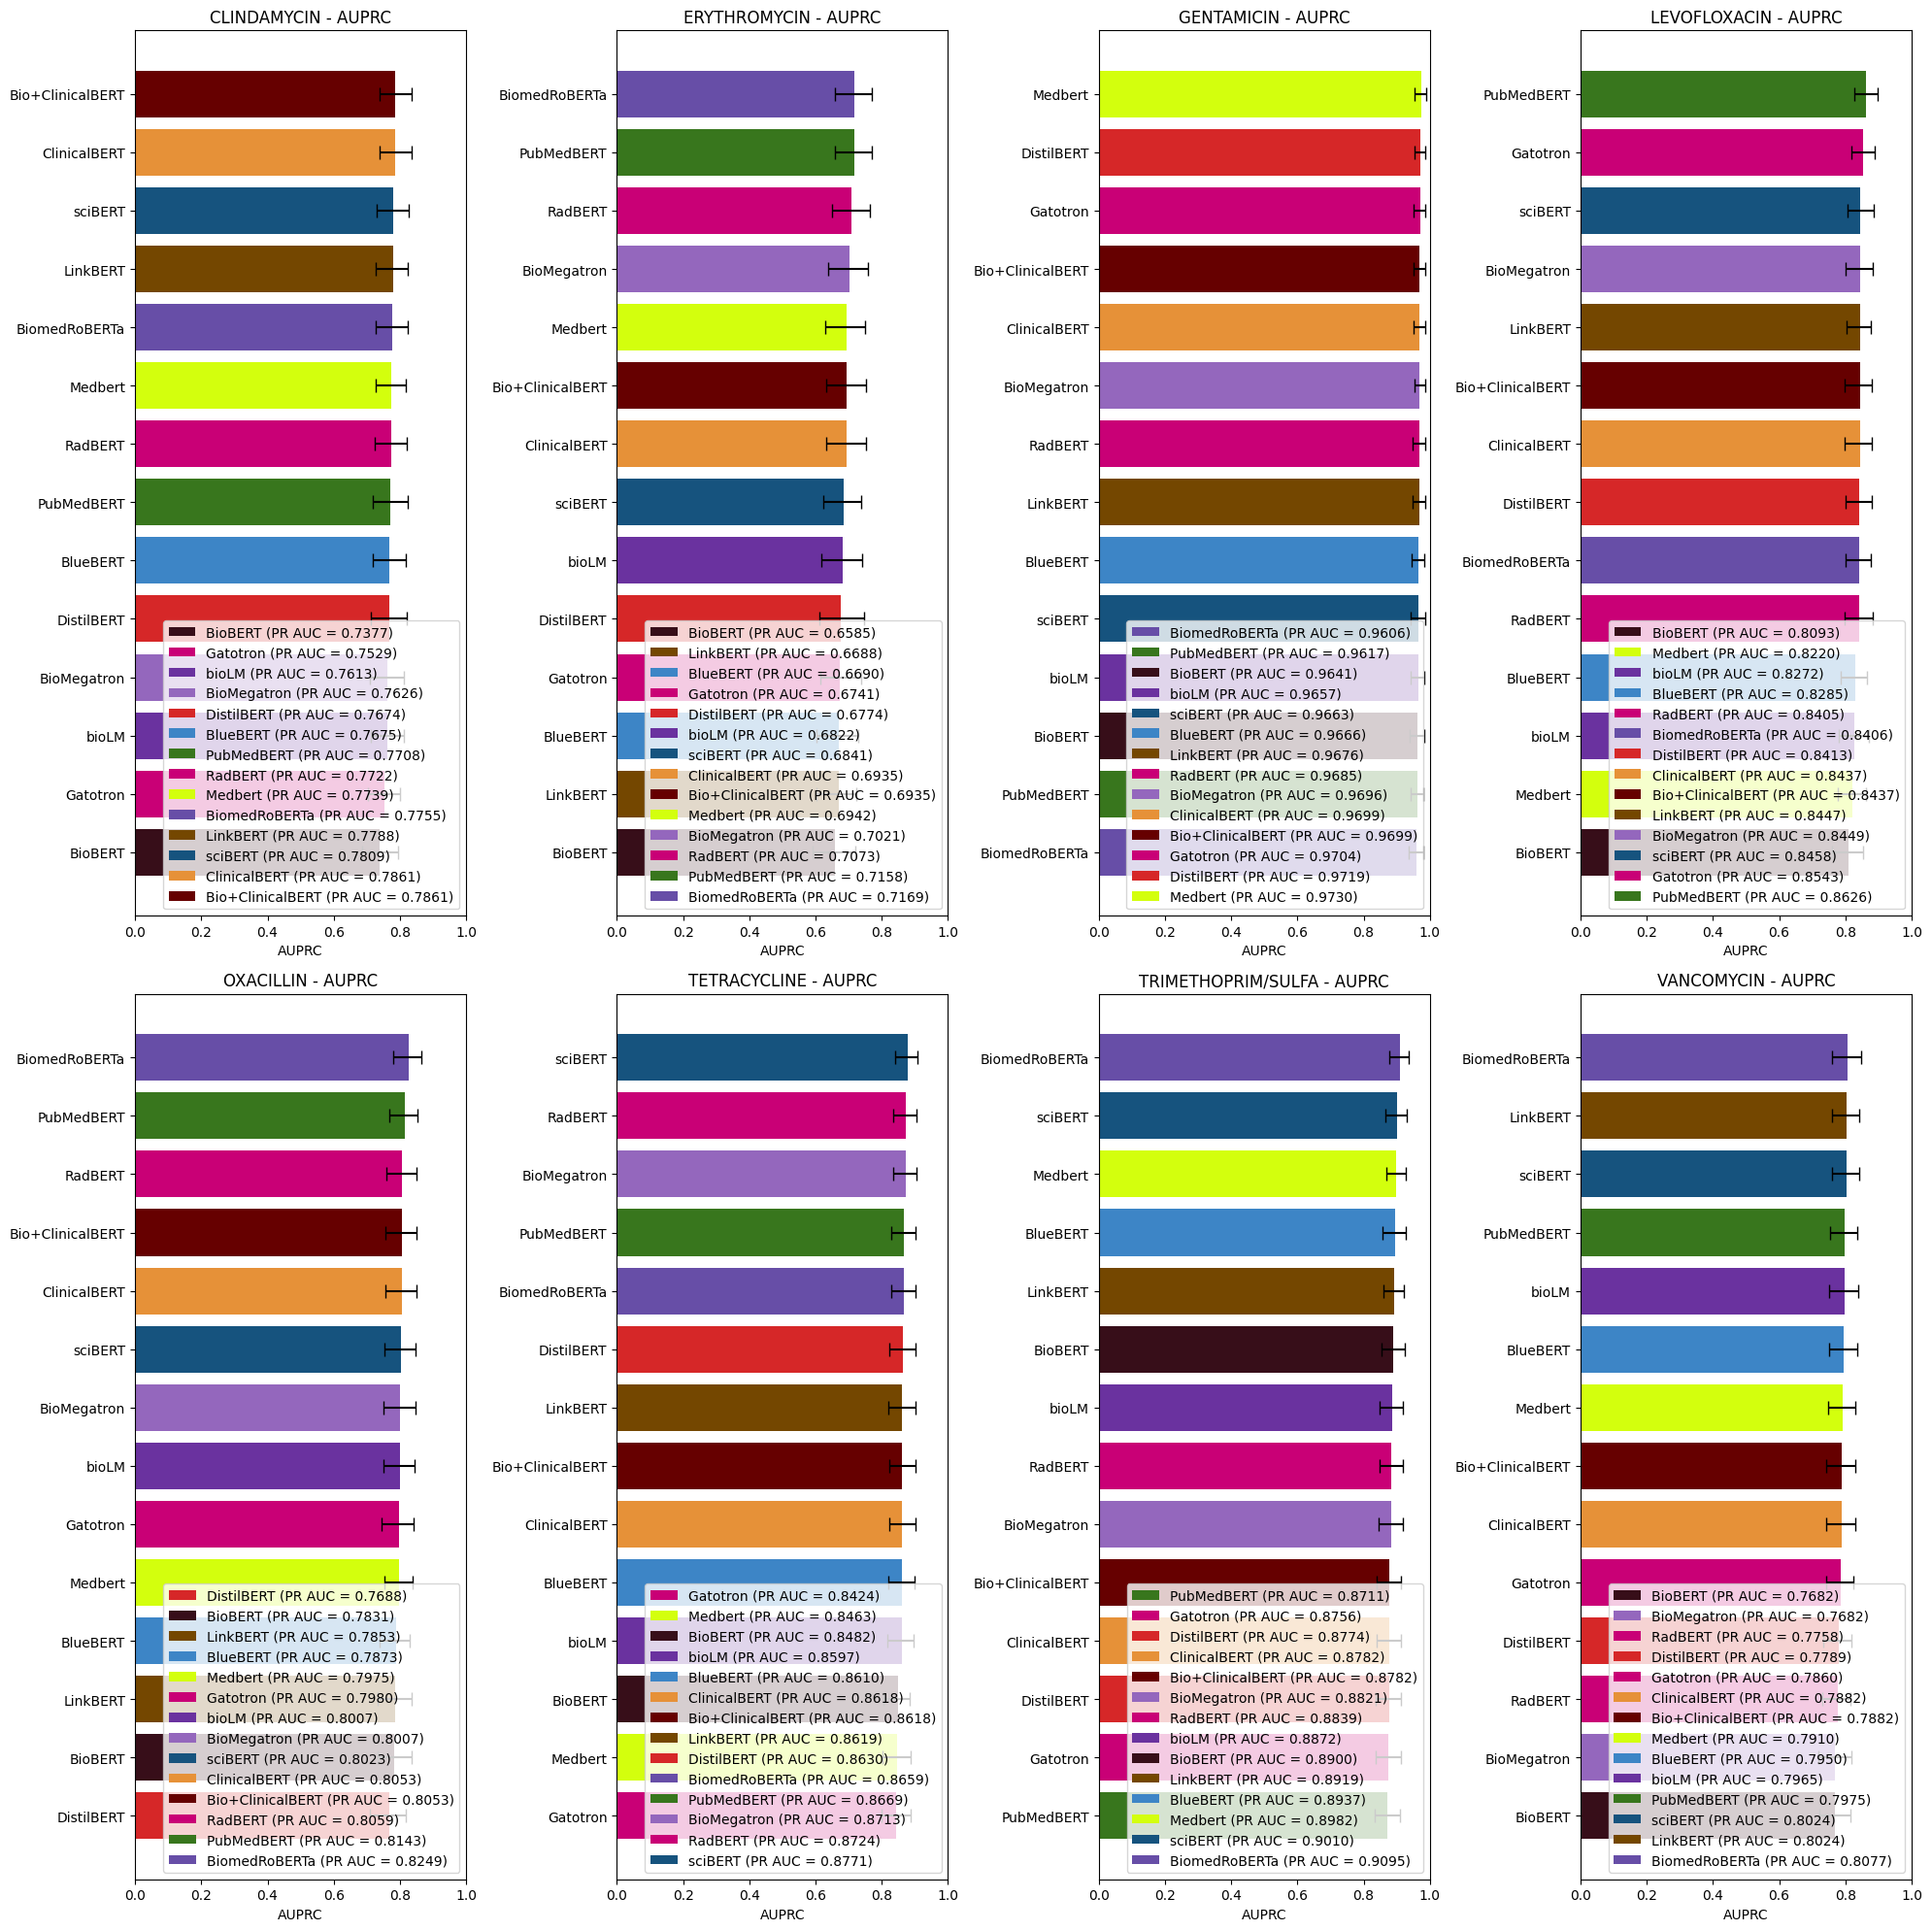

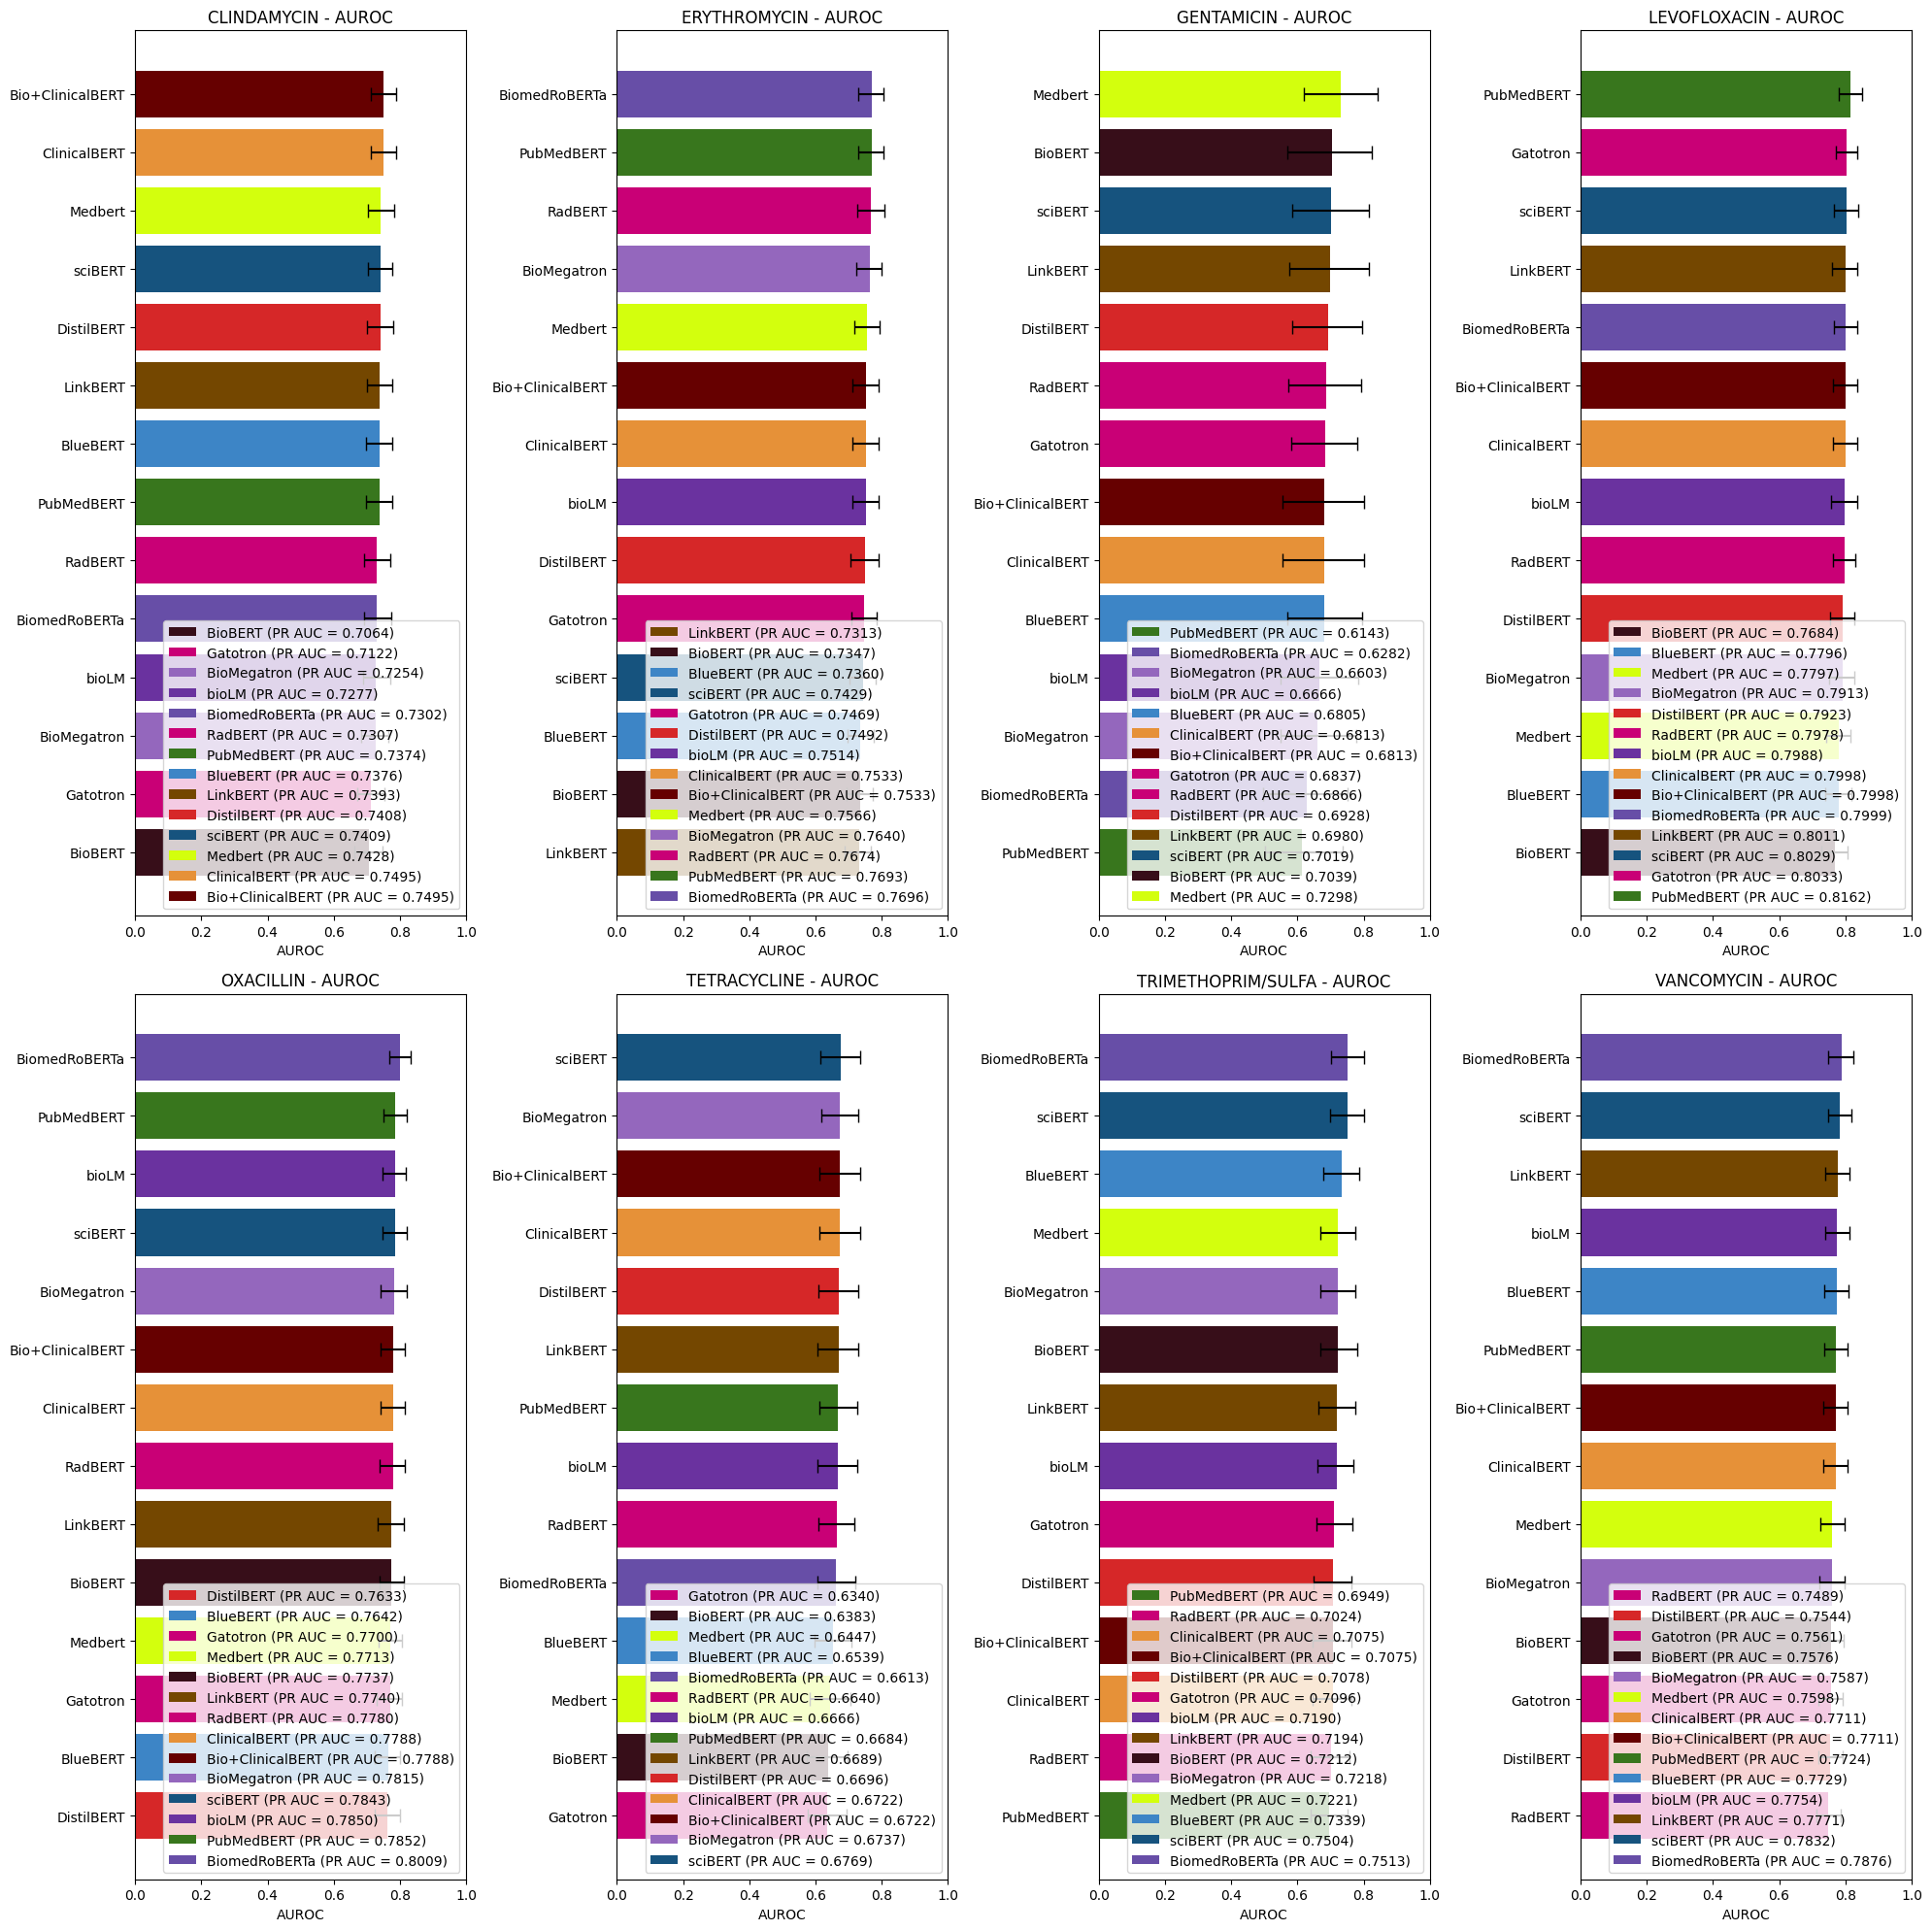

In [41]:
plot_bar_auprc(antibiotics, dictionaries, model_colors)
plot_bar_auroc(antibiotics, dictionaries, model_colors)

In [43]:
def compute_average_rank(antibiotics, dictionaries, metric):
    """
    Computes the average rank for each model across all antibiotics based on AUROC values.

    Parameters:
    - antibiotics: List of antibiotics
    - dictionaries: List of tuples containing (dictionary, model_name)

    Returns:
    - Dictionary with each model and their average rank across all antibiotics
    """
    model_ranks = {name: [] for _, name in dictionaries}  # Initialize dictionary to store ranks for each model

    # Loop through each antibiotic
    for antibiotic in antibiotics:
        # Sort the dictionaries based on AUROC values for each antibiotic, descending order (best to worst)
        sorted_dictionaries = sorted(dictionaries, key=lambda x: x[0][antibiotic]['Test Metrics'][metric], reverse=True)
        
        # Record the rank of each model for this antibiotic
        for rank, (_, name) in enumerate(sorted_dictionaries, start=1):
            model_ranks[name].append(rank)

    # Compute the average rank for each model
    average_ranks = {name: sum(ranks) / len(ranks) for name, ranks in model_ranks.items()}
    sorted_average_ranks = dict(sorted(average_ranks.items(), key=lambda item: item[1]))

    return sorted_average_ranks

rank_roc = compute_average_rank(antibiotics, dictionaries, "ROC AUC")
rank_prc = compute_average_rank(antibiotics, dictionaries, "PRC AUC")

print(rank_roc, "\n",rank_prc)

{'sciBERT': 3.75, 'BiomedRoBERTa': 5.25, 'ClinicalBERT': 6.0, 'LinkBERT': 6.625, 'PubMedBERT': 6.75, 'Bio+ClinicalBERT': 7.0, 'Medbert': 7.125, 'BioMegatron': 7.625, 'bioLM': 7.625, 'DistilBERT': 8.875, 'RadBERT': 8.875, 'BlueBERT': 9.25, 'Gatotron': 9.875, 'BioBERT': 10.375} 
 {'sciBERT': 4.375, 'BiomedRoBERTa': 4.75, 'ClinicalBERT': 5.75, 'PubMedBERT': 5.875, 'RadBERT': 6.375, 'Bio+ClinicalBERT': 6.75, 'BioMegatron': 7.25, 'Medbert': 7.25, 'LinkBERT': 7.25, 'DistilBERT': 9.125, 'BlueBERT': 9.25, 'bioLM': 9.25, 'Gatotron': 9.375, 'BioBERT': 12.375}
